In [ ]:
import os
os.chdir("/path/to/workspace")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.gridspec as gridspec
import torch
from matplotlib import font_manager
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

flesch2018comparing
(13200,)

schulz2020finding
(21000,)

tomov2021multitask
(7878,)

collsi枚枚2023MCPL
(6136,)

wu2018generalisation
(360,)

wu2018generalisation
wu2018generalisation
collsi枚枚2023MCPL
collsi枚枚2023MCPL
flesch2018comparing
flesch2018comparing
tomov2021multitask
tomov2021multitask


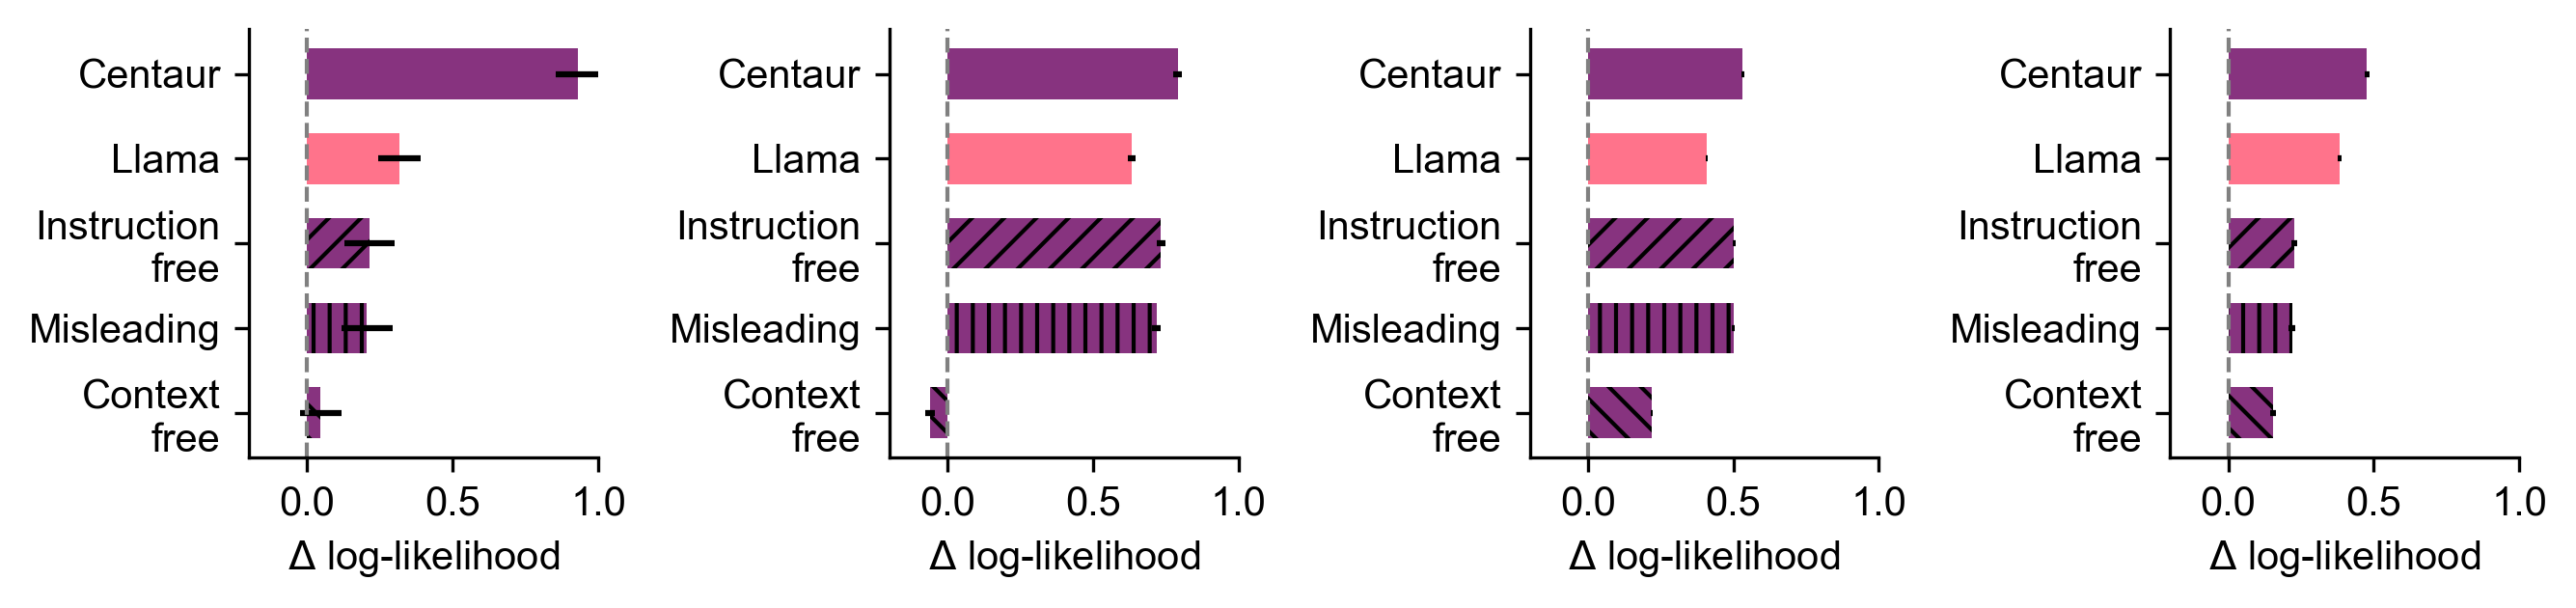

In [ ]:
centaur_70b = torch.load('results/centaur-normal.pth')
llama_70b = torch.load('results/llama-normal.pth')
c_instruction_free = torch.load('results/centaur-instruction_free.pth')
c_misleading = torch.load('results/centaur-misleading_instruction.pth')
c_context_free = torch.load('results/centaur-context_free.pth')

means = {}
sems = {}
task_lst = ['wu2018generalisation',
            'collsi枚枚2023MCPL', # handle wrong encodings
            'flesch2018comparing',
            'tomov2021multitask']

baselines_full = torch.load('results/custom_metrics_full_log_likelihoods_baselines.pth')
statics_comp = {}
for key in llama_70b.keys():
    print(key)
    centaur_70b[key] = centaur_70b[key][1]
    llama_70b[key] = llama_70b[key][1]
    c_instruction_free[key] = c_instruction_free[key][1]
    c_context_free[key] = c_context_free[key][1]
    c_misleading[key] = c_misleading[key][1]
    
    if key == 'collsi枚枚2023MCPL':
        baseline = baselines_full['collsiöö2023MCPL']
    else:
        baseline = baselines_full[key]
    baseline = baseline.mean().item()
    print(centaur_70b[key].shape)
    centaur_relative = -centaur_70b[key] + baseline
    llama_relative = -llama_70b[key] + baseline
    int_relative = -c_instruction_free[key] + baseline
    int_context = -c_context_free[key] + baseline
    intf_relative = -c_misleading[key] + baseline
    statics_comp[key] = [centaur_relative, llama_relative,
                        int_relative, int_context, intf_relative]
    means[key] = []
    sems[key] = []
    means[key].append(centaur_relative.mean())
    means[key].append(llama_relative.mean())
    means[key].append(int_relative.mean())
    means[key].append(intf_relative.mean())
    means[key].append(int_context.mean())

    sems[key].append(centaur_relative.std() / math.sqrt(len(centaur_relative)))
    sems[key].append(llama_relative.std() / math.sqrt(len(llama_relative)))
    sems[key].append(int_relative.std() / math.sqrt(len(int_relative)))
    sems[key].append(intf_relative.std() / math.sqrt(len(intf_relative)))
    sems[key].append(int_context.std() / math.sqrt(len(int_context)))

    print()


from matplotlib.ticker import FixedLocator, NullLocator

gs = gridspec.GridSpec(1, 4, width_ratios=[0.25, 0.25, 0.25,0.25])
offsets = [0.01, 0.01, 0.01,0.01]
fig = plt.figure(figsize=(9, 2.2))
for task_index, task in enumerate(task_lst):
    print(task)
    ax = fig.add_subplot(gs[:, task_index])
    ax.barh(np.arange(5), means[task][::-1], 
            xerr=sems[task][::-1], height=0.6,
            color=['#69005f', '#ff506e','#69005f', '#69005f', '#69005f'][::-1])

    ax.set_yticks(np.arange(5, dtype=int))  # 设置刻度位置
    ax.set_yticklabels(['Centaur', 'Llama', 'Instruction\nfree', 'Misleading', 'Context\nfree'][::-1])  # 设置刻度标签

    ax.yaxis.set_major_locator(FixedLocator(np.arange(5)))

    ax.yaxis.set_minor_locator(NullLocator())

    ax.set_xlabel(r'$\Delta$ log-likelihood')
    ax.set_xticks([0,0.5,1.0])
    ax.axvline(x=0, color='grey', linestyle='--', linewidth=1.0)
    ax.containers[1][0].set_alpha(0.8)
    ax.containers[1][1].set_alpha(0.8)
    ax.containers[1][2].set_alpha(0.8)
    ax.containers[1][3].set_alpha(0.8)
    ax.containers[1][4].set_alpha(0.8)
    
    ax.containers[1][2].set_hatch('///')
    ax.containers[1][1].set_hatch('|||')
    ax.containers[1][0].set_hatch('\\\\\\')

    ax.set_xlim(-0.2, 1)

    sns.despine(ax=ax,top=True, right=True, left=False, bottom=False)
    ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    print(task)
plt.tight_layout()
# plt.savefig("img/fig1.svg", format="svg", bbox_inches='tight')

plt.show()
